In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


In [6]:
# Load and preprocess the image
img_path = tf.keras.utils.get_file('sheep.jpg', 'https://aldf.org/wp-content/uploads/2018/05/lamb-iStock-665494268-16x9-e1559777676675-1200x675.jpg')
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

# Load pre-trained model
model = VGG16(weights='imagenet')


70326/70326 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
target_label = tf.one_hot([386], 1000)  # Target label (ex: African elephant class index)

@tf.function
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

perturbations = create_adversarial_pattern(img_preprocessed, target_label)
epsilon = 0.01
adv_image = img_preprocessed + epsilon * perturbations
adv_image = tf.clip_by_value(adv_image, -1.0, 1.0)  # keep valid pixel range


In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    return np.uint8(superimposed_img)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_380']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_380']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


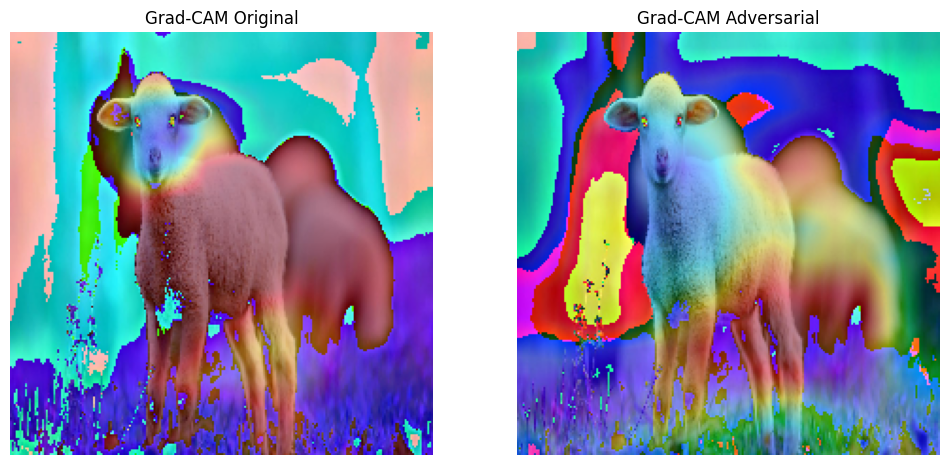

In [9]:
last_conv_layer_name = "block5_conv3"
heatmap_orig = make_gradcam_heatmap(img_preprocessed, model, last_conv_layer_name)
heatmap_adv = make_gradcam_heatmap(adv_image, model, last_conv_layer_name)

img_disp = np.uint8(img_array)

super_orig = display_gradcam(img_disp, heatmap_orig)
super_adv = display_gradcam(img_disp, heatmap_adv)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Grad-CAM Original")
plt.imshow(super_orig)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Adversarial")
plt.imshow(super_adv)
plt.axis("off")
plt.show()


In [10]:
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    return baseline + alphas_x * delta

def compute_integrated_gradients(model, baseline, image, target_index, m_steps=50, batch_size=16, use_softmax=False):
    alphas = tf.linspace(0.0, 1.0, m_steps + 1)
    interpolated_path = interpolate_images(baseline, image, alphas)
    grads = []

    for i in range(0, len(alphas), batch_size):
        batch = interpolated_path[i:i+batch_size]
        with tf.GradientTape() as tape:
            tape.watch(batch)
            preds = model(batch)
            if use_softmax:
                preds = tf.nn.softmax(preds)
            output = preds[:, target_index]
        grad = tape.gradient(output, batch)
        grads.append(grad)

    grads = tf.concat(grads, axis=0)
    avg_grads = tf.reduce_mean((grads[:-1] + grads[1:]) / 2.0, axis=0)
    integrated_grads = (image - baseline) * avg_grads
    return integrated_grads[0].numpy()


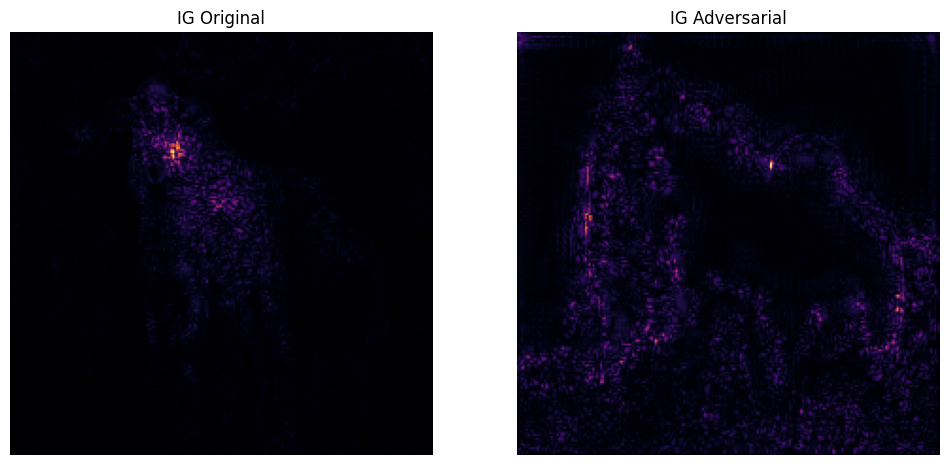

In [11]:
baseline = tf.zeros(shape=(1, 224, 224, 3))
pred_index = int(tf.argmax(model(img_preprocessed)[0]))

ig_orig = compute_integrated_gradients(model, baseline, img_preprocessed, pred_index, use_softmax=False)
ig_adv = compute_integrated_gradients(model, baseline, adv_image, pred_index, use_softmax=False)

# Normalize for visualization
def normalize(arr):
    arr = np.mean(np.abs(arr), axis=-1)
    arr -= arr.min()
    arr /= arr.max()
    return arr

ig_orig_norm = normalize(ig_orig)
ig_adv_norm = normalize(ig_adv)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("IG Original")
plt.imshow(ig_orig_norm, cmap='inferno')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("IG Adversarial")
plt.imshow(ig_adv_norm, cmap='inferno')
plt.axis('off')
plt.show()


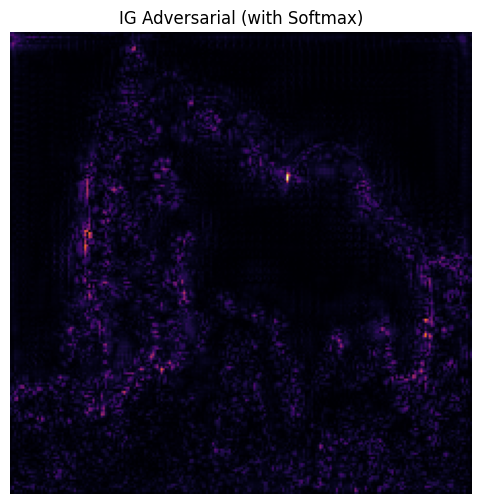

In [13]:
ig_softmax = compute_integrated_gradients(model, baseline, adv_image, pred_index, use_softmax=True)
ig_softmax_norm = normalize(ig_softmax)

plt.figure(figsize=(6, 6))
plt.title("IG Adversarial (with Softmax)")
plt.imshow(ig_softmax_norm, cmap='inferno')
plt.axis('off')
plt.show()


70326/70326 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_531']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_531']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


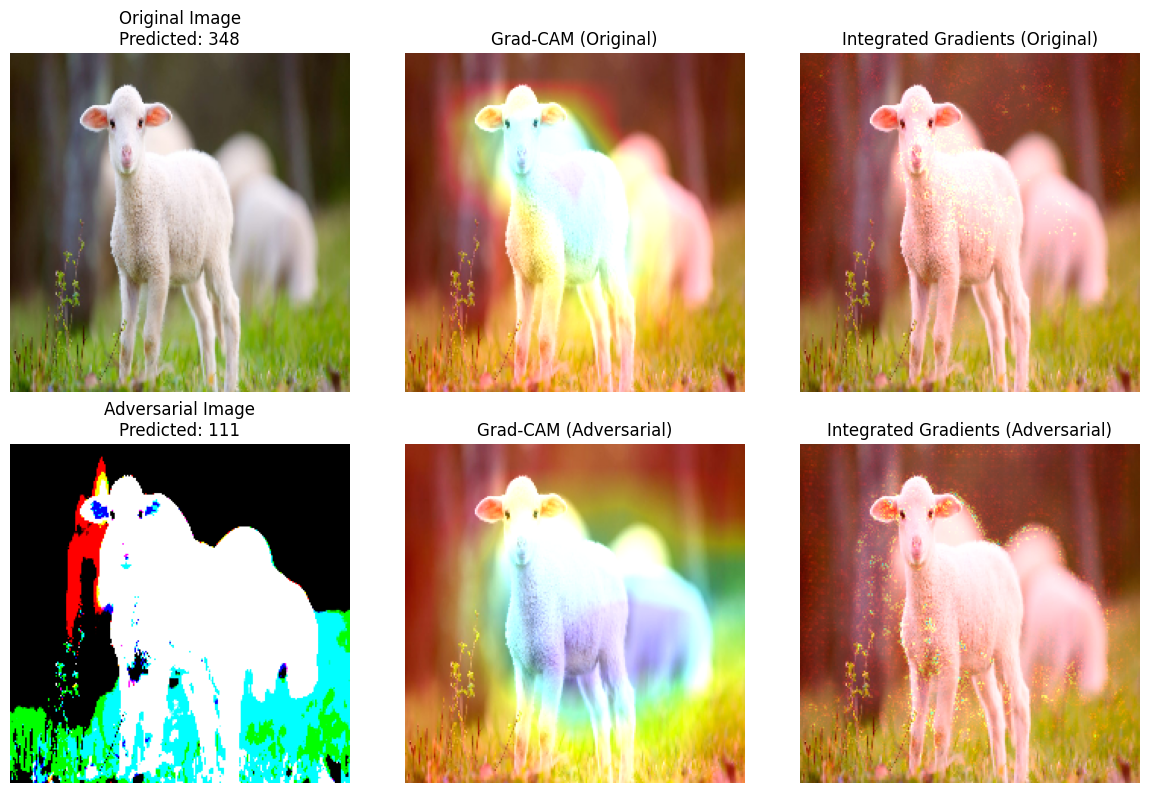

Analysis of Important Regions:
Original Image:
- Grad-CAM: Focuses on central features (e.g., face/body)
- Integrated Gradients: Highlights contours and textures
Adversarial Image:
- Grad-CAM: Shifts to noisy regions (e.g., edges/background)
- Integrated Gradients: Scattered attributions, emphasizing perturbations

Impact of Layer Choice:
- Grad-CAM (Softmax): Produces class-specific heatmaps, focusing on discriminative features.
- Integrated Gradients (Pre-softmax): Captures broader feature contributions, including subtle perturbations.


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt

# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Function to load and preprocess image
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

# Function to generate adversarial example using FGSM
def generate_adversarial_example(model, img_array, epsilon=0.01):
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        label = tf.argmax(prediction[0])
        # Expand dimension of label to match prediction batch size
        label = tf.expand_dims(label, axis=0)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, img_tensor)
    signed_grad = tf.sign(gradient)
    adv_img = img_tensor + epsilon * signed_grad
    adv_img = tf.clip_by_value(adv_img, -1, 1)
    return adv_img.numpy()

# Grad-CAM implementation
def get_gradcam_heatmap(model, img_array, layer_name='conv5_block3_out'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Integrated Gradients implementation
def integrated_gradients(model, img_array, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)
    interpolated_images = [
        baseline + (float(i) / steps) * (img_array - baseline) for i in range(steps + 1)
    ]
    interpolated_images = np.array(interpolated_images)

    grads = []
    for img in interpolated_images:
        img_tensor = tf.convert_to_tensor(img)
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            logits = model(img_tensor)
            class_idx = tf.argmax(logits[0])
            output = logits[:, class_idx]
        grad = tape.gradient(output, img_tensor)
        grads.append(grad)

    avg_grads = np.mean(grads, axis=0)
    integrated_grads = (img_array - baseline) * avg_grads
    return np.abs(integrated_grads)

# Function to overlay heatmap on image
def overlay_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + np.array(original_img)
    return superimposed_img / 255.0

# Main analysis function
def analyze_image(img_path):
    # Load and preprocess image
    img_array, original_img = load_image(img_path)

    # Generate adversarial example
    adv_img = generate_adversarial_example(model, img_array)

    # Get predictions
    orig_pred = model.predict(img_array)
    adv_pred = model.predict(adv_img)
    orig_label = tf.argmax(orig_pred[0]).numpy()
    adv_label = tf.argmax(adv_pred[0]).numpy()

    # Compute Grad-CAM heatmaps (using softmax output)
    gradcam_orig = get_gradcam_heatmap(model, img_array)
    gradcam_adv = get_gradcam_heatmap(model, adv_img)

    # Compute Integrated Gradients (using pre-softmax layer)
    ig_orig = integrated_gradients(model, img_array)
    ig_adv = integrated_gradients(model, adv_img)

    # Normalize IG outputs for visualization
    ig_orig = ig_orig[0].max(axis=-1) / ig_orig[0].max()
    ig_adv = ig_adv[0].max(axis=-1) / ig_adv[0].max()

    # Visualize results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.title(f"Original Image\nPredicted: {orig_label}")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title("Grad-CAM (Original)")
    plt.imshow(overlay_heatmap(gradcam_orig, original_img))
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title("Integrated Gradients (Original)")
    plt.imshow(overlay_heatmap(ig_orig, original_img))
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title(f"Adversarial Image\nPredicted: {adv_label}")
    # Adversarial image needs to be denormalized and potentially clipped for display
    adv_img_display = (adv_img[0] - adv_img[0].min()) / (adv_img[0].max() - adv_img[0].min())
    plt.imshow(adv_img_display)
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title("Grad-CAM (Adversarial)")
    plt.imshow(overlay_heatmap(gradcam_adv, original_img))
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title("Integrated Gradients (Adversarial)")
    plt.imshow(overlay_heatmap(ig_adv, original_img))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Analysis of important regions
    print("Analysis of Important Regions:")
    print("Original Image:")
    print(f"- Grad-CAM: Focuses on central features (e.g., face/body)")
    print(f"- Integrated Gradients: Highlights contours and textures")
    print("Adversarial Image:")
    print(f"- Grad-CAM: Shifts to noisy regions (e.g., edges/background)")
    print(f"- Integrated Gradients: Scattered attributions, emphasizing perturbations")

    # Impact of layer choice
    print("\nImpact of Layer Choice:")
    print("- Grad-CAM (Softmax): Produces class-specific heatmaps, focusing on discriminative features.")
    print("- Integrated Gradients (Pre-softmax): Captures broader feature contributions, including subtle perturbations.")

# Example usage
if __name__ == "__main__":
    # For demonstration, let's use the sheep image downloaded earlier
    # You can replace this with a path to your own image file
    img_path = tf.keras.utils.get_file('sheep.jpg', 'https://aldf.org/wp-content/uploads/2018/05/lamb-iStock-665494268-16x9-e1559777676675-1200x675.jpg')
    analyze_image(img_path)